# Homework 13

### Aim
Perform object detection on images using Keras by applying YOLOv3 model.

### Code Documentation
<br>
This document describes the tasks that are performed in the source code.

**Introduction:** The code is designed to build a convolutional autoencoder model for image reconstruction. The model will be trained using images of sunflowers and tested using separate sets of sunflower images as well as images of roses.

**Data Preprocessing:** The code imports necessary libraries and sets up paths to image data. The dataset consists of five types of flowers, but for this task, the focus is on the sunflower class. The sunflower images are split into training and testing sets and stored in separate directories.

The code defines the size of input images and creates data generators using the ImageDataGenerator class from Keras. The batch size is set to 85.

**Model Architecture:** The code defines the architecture of the convolutional autoencoder using the Keras Sequential model. The input shape must match the size of the images that will be fed into the model by the generators. The output layer must be the same size as the original image. The model consists of convolutional and max pooling layers, as well as upsampling layers to reconstruct the image.

**Model Training:** The code compiles the model using the 'adadelta' optimizer and the mean squared error loss function. It sets up early stopping and model checkpoint callbacks to monitor the validation loss during training and save the best model.

The model is trained using the fit method, with the data generators created earlier as input. The number of epochs to train for and the validation generator to use for monitoring the validation loss are specified. The model is saved in the specified directory after each epoch.

**Model Evaluation:** The code evaluates the model using the test generator and the anomaly generator, which contains images of roses. The evaluate method calculates the mean squared error loss on both sets of images. The predict method is used to reconstruct sample images from the test set. The original and reconstructed images are visualized side by side using Matplotlib.


In [67]:
import struct
import numpy as np
from numpy import expand_dims

from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from keras.models import Model
from keras.models import load_model

from numpy import expand_dims
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [68]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


Define a convolutional block with multiple convolutional layers, batch normalization, and leaky ReLU activation. It takes the input tensor inp and a list of convolutional layers convs as inputs. The function iterates over the convolutional layers and applies convolution, batch normalization, and activation functions. It also handles the skip connections by storing the current layer's output and adding it with the input tensor at the end. The function returns the output tensor.

### Create the YOLOv3 model.

In [69]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model


Define a function that creates a YOLOv3 model using convolutional layers. The model takes an image as input and applies a series of convolutional layers with varying filter sizes and kernel sizes. The output of the model is a set of predicted bounding boxes for objects in the input image.

In [70]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0


A class named WeightReader that reads weights from a binary file and loads them into a given Keras model. It uses the struct module to unpack the binary data, and numpy to convert it to arrays. The weights are loaded into convolutional layers and batch normalization layers of the model. The class also has a reset method that sets the offset to 0 to read the weights from the beginning of the file again.

### Download and save the pre-trained model weights

In [71]:
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

Define a YOLOv3 model using the function make_yolov3_model(), loads pre-trained weights from a file using the WeightReader class, sets the loaded weights into the model using weight_reader.load_weights(model), and saves the model to a file named model.h5 using model.save('model.h5').

In [72]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

Load an image and prepare it for input to a YOLOv3 model. First, the function loads the image to get its original shape (width and height). Then, it loads the image again with the desired size and converts it to a numpy array. Next, it scales the pixel values to be between 0 and 1 and adds a dimension to the array to create a batch of one sample (since the YOLOv3 model expects batches of images as input). Finally, the function returns the preprocessed image, as well as the original width and height of the image.

In [73]:
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

1/1 [==============================] - 1s 960ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


Load a saved YOLOv3 model from a file, sets the expected input shape, loads an image, prepares it by resizing and scaling its pixel values, passes it through the model to make a prediction, and prints the shape of the output.

In [74]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

Define a BoundBox class which represents a bounding box for an object detected in an image. It has attributes for the minimum and maximum x and y coordinates of the box, the objectness score and the class probabilities. It has methods to get the predicted class label and score.

In [75]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


In [76]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

The decode_netout() takes the output of the YOLOv3 model and decodes it into a list of BoundBox objects, each representing a predicted object in the image. The function first reshapes the model output and applies some transformations to the output values to get the box coordinates, objectness score, and class probabilities. It then loops over all the cells in the output grid, computes the box coordinates and objectness score, and appends a BoundBox object to the boxes list. Finally, the function returns the list of BoundBox objects.

In [77]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)


This function takes in a list of BoundBox objects, which represent predicted object bounding boxes in the YOLO format, as well as the original dimensions of the input image and the dimensions that the image was resized to before being passed through the YOLO model. It adjusts the coordinates of the bounding boxes to account for the resizing of the image and returns the updated list of boxes.

In [78]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3


The _interval_overlap() function calculates the overlap between two intervals. It takes as input two intervals represented as tuples (x1, x2) and (x3, x4), and returns the length of their overlap. If the intervals do not overlap, it returns 0.

In [79]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union


The bbox_iou() function calculates the intersection over union (IoU) metric between two bounding boxes. It takes as input two BoundBox objects (box1 and box2) and returns the IoU value as a float. The IoU metric measures the overlap between two bounding boxes, where an IoU of 1 indicates a perfect overlap and an IoU of 0 indicates no overlap. The calculation involves finding the intersection of the two boxes, which is the area where the boxes overlap, and then dividing it by the union of the two boxes, which is the total area covered by both boxes.

In [80]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0


The do_nms() function performs non-maximum suppression (NMS) on a list of bounding boxes to remove overlapping boxes and keep only the ones with the highest confidence scores for each object class. The function takes in the list of bounding boxes and a threshold value for NMS and modifies the input list by setting the confidence scores of overlapping boxes to zero.

In [81]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height


This function load_image_pixels() loads and prepares an image for input into a machine learning model. It takes in a filename and a target shape as inputs. The function loads the image from the file and gets its original width and height. Then it resizes the image to the target shape, converts it to a numpy array, scales the pixel values to be between 0 and 1, and adds an extra dimension to create a batch of one image. The function returns the preprocessed image, as well as the original width and height of the image.

In [82]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores


The get_boxes() function takes in a list of boxes, a list of labels, and a threshold value thresh. It iterates through all the boxes and all the possible labels, and checks if the confidence score for the box and the label is higher than the given threshold. If it is, then it adds the box, label, and score (multiplied by 100) to three separate lists. It then returns these three lists: v_boxes, v_labels, and v_scores.

In [83]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()


The draw_boxes() function that takes in an image filename, a list of bounding boxes (v_boxes), a list of corresponding labels (v_labels), and a list of scores (v_scores) and draws the bounding boxes and labels on the image.

It first loads the image using pyplot.imread() and displays it using pyplot.imshow(). It then gets the context for drawing boxes using pyplot.gca(). For each bounding box, it gets the coordinates of the box, calculates the width and height of the box, creates a Rectangle object using these values, and adds the rectangle to the plot using ax.add_patch(rect). It also adds the label and score to the top left corner of the box using pyplot.text(). Finally, it displays the plot using pyplot.show().

In [84]:
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

1/1 [==============================] - 1s 962ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


Load a pre-trained YOLOv3 object detection model and uses it to make predictions on a given image. It first defines the expected input shape for the model and loads and prepares the image accordingly. It then passes the image through the model to obtain predictions in the form of a list of arrays. The code then defines the anchors and probability threshold for detected objects, and uses the decode_netout function to decode the output of the network and obtain bounding boxes around the detected objects. The final result is a list of Box objects representing the detected objects in the image.

### Make a prediction on three images of your choice (e.g., images of people, animals, objects etc.) and report the model’s output.

1/1 [==============================] - 1s 954ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 99.82818365097046
zebra 93.60967874526978
zebra 97.3427951335907


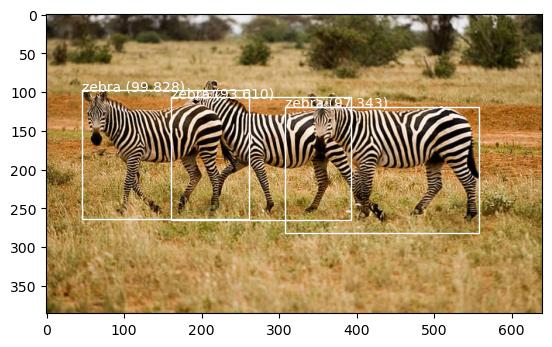

1/1 [==============================] - 0s 435ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.93948340415955
person 99.97729063034058
person 98.68218898773193
pottedplant 64.2717719078064
person 99.89782571792603
person 99.84126687049866
chair 97.2052812576294
chair 94.45980191230774


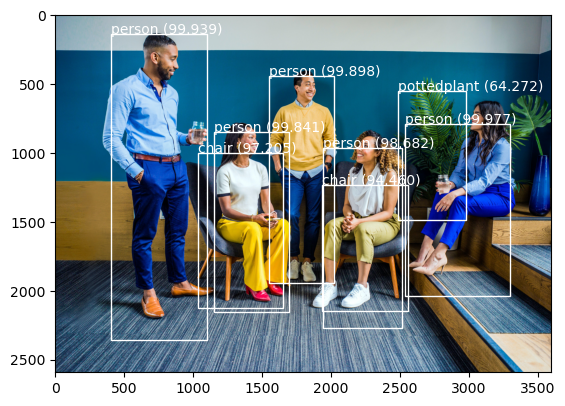

1/1 [==============================] - 0s 433ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
sofa 99.88387823104858
pottedplant 91.31060242652893
vase 91.27545356750488
vase 94.16660070419312
vase 75.73054432868958


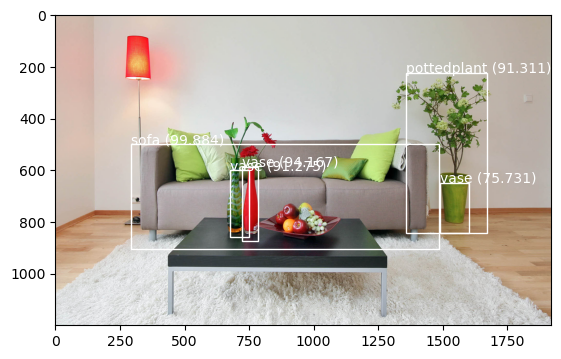

In [85]:
# load yolov3 model
model = load_model('model.h5')

# define the expected input shape for the model
input_w, input_h = 416, 416

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6

# define the non-max suppression threshold
nms_threshold = 0.3

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# define the list of image filenames
photo_filenames = ['zebra.jpg', 'people.jpeg', 'liv.jpeg']

# process each image
for photo_filename in photo_filenames:

    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

    # make prediction
    yhat = model.predict(image)

    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])

    # decode the output of the network
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # suppress non-maximal boxes
    do_nms(boxes, nms_threshold)

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])

    # draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)


Used a trained YOLOv3 model to detect objects in an image. It loads the model and the image, prepares the image for input into the model, makes a prediction, and then processes the output to detect objects in the image. The detected objects are then labeled with their class names and confidence scores, and bounding boxes are drawn around them in the image. The final result is an image with labeled objects and bounding boxes.

### What is the purpose of the non-max suppression?


The purpose of non-max suppression (NMS) is to remove overlapping bounding boxes of the same object detected by the object detection model. After applying object detection, there may be multiple bounding boxes that represent the same object in an image. Non-max suppression removes these duplicate detections by selecting the box with the highest confidence score and suppressing the others. This helps to improve the accuracy of object detection and reduces the number of false positives.

### Non-max suppression threshold = 0.3

1/1 [==============================] - 1s 961ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 99.82818365097046
zebra 93.60967874526978
zebra 97.3427951335907


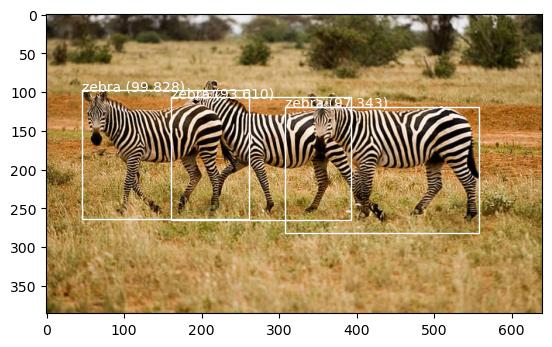

1/1 [==============================] - 0s 440ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.93948340415955
person 99.97729063034058
person 98.68218898773193
pottedplant 64.2717719078064
person 99.89782571792603
person 99.84126687049866
chair 97.2052812576294
chair 94.45980191230774


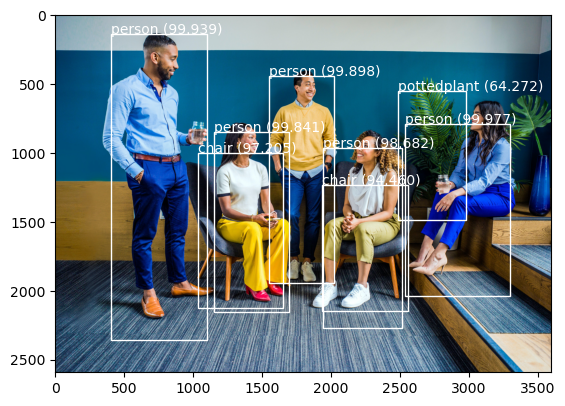

1/1 [==============================] - 0s 450ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
sofa 99.88387823104858
pottedplant 91.31060242652893
vase 91.27545356750488
vase 94.16660070419312
vase 75.73054432868958


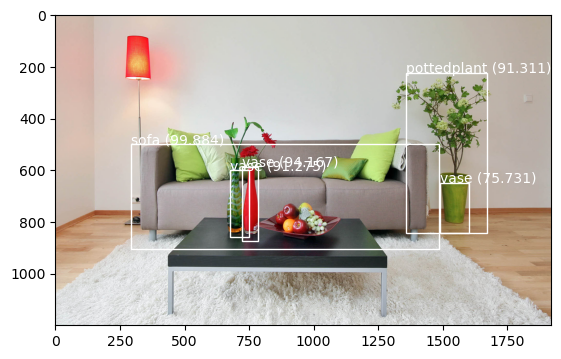

In [86]:
# load yolov3 model
model = load_model('model.h5')

# define the expected input shape for the model
input_w, input_h = 416, 416

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6

# define the non-max suppression threshold
nms_threshold = 0.3

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# define the list of image filenames
photo_filenames = ['zebra.jpg', 'people.jpeg', 'liv.jpeg']

# process each image
for photo_filename in photo_filenames:

    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

    # make prediction
    yhat = model.predict(image)

    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])

    # decode the output of the network
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # suppress non-maximal boxes
    do_nms(boxes, nms_threshold)

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])

    # draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)


### Non-max suppression threshold = 0.8

1/1 [==============================] - 1s 951ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 99.82818365097046
zebra 93.60967874526978
zebra 89.65444564819336
zebra 86.99327111244202
zebra 97.3427951335907


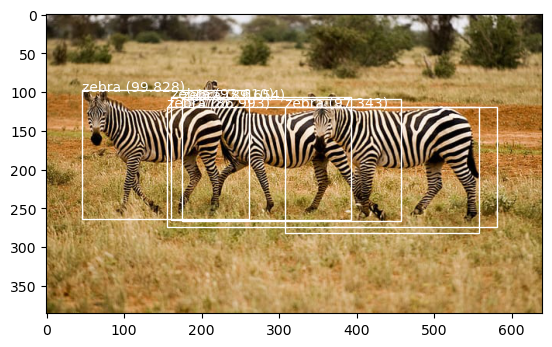

1/1 [==============================] - 0s 443ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.93948340415955
person 99.97729063034058
person 60.330647230148315
person 98.68218898773193
pottedplant 64.2717719078064
person 99.89782571792603
person 86.30483746528625
person 82.90793895721436
person 99.84126687049866
person 72.29125499725342
chair 82.80170559883118
chair 97.2052812576294
chair 92.24706888198853
chair 78.11444401741028
chair 94.45980191230774


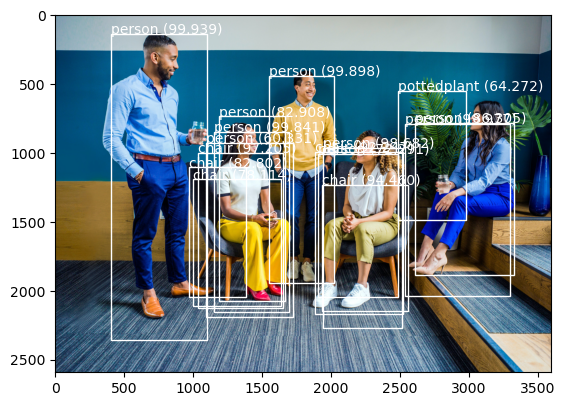

1/1 [==============================] - 0s 439ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
sofa 99.88387823104858
pottedplant 91.31060242652893
vase 91.27545356750488
vase 94.16660070419312
vase 75.73054432868958


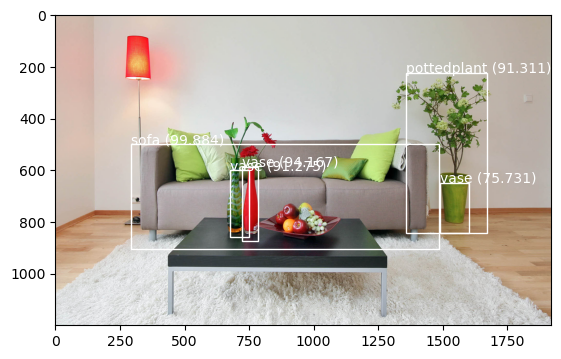

In [87]:
# load yolov3 model
model = load_model('model.h5')

# define the expected input shape for the model
input_w, input_h = 416, 416

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6

# define the non-max suppression threshold
nms_threshold = 0.8

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# define the list of image filenames
photo_filenames = ['zebra.jpg', 'people.jpeg', 'liv.jpeg']

# process each image
for photo_filename in photo_filenames:

    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

    # make prediction
    yhat = model.predict(image)

    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])

    # decode the output of the network
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # suppress non-maximal boxes
    do_nms(boxes, nms_threshold)

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])

    #draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)


When using a lower non-max suppression threshold of 0.3, fewer bounding boxes are retained, resulting in fewer detections. This increases the number of false positive detections and may result in lower precision.

When using a higher non-max suppression threshold of 0.8, more bounding boxes are retained, resulting in more detections. This increases the likelihood of missing some true positive detections and may result in lower recall.